## Web App Layer

In [1]:
!pip install flask qrcode pillow azure-storage-blob


In [1]:
from azure.storage.blob import BlobServiceClient

# Azure Storage connection string here
AZURE_STORAGE_CONNECTION_STRING = "DefaultEndpointsProtocol=https;AccountName=json1signal;AccountKey=b9NcBebFgzzcArkSw0ouZF1OcFBQ/PF4OXzffW9KYt/qd+XNnj1wvdckFZO2oD2RdZwjLSMP+8ce+AStu9Spkg==;EndpointSuffix=core.windows.net"

# Creating Blob service client
blob_service_client = BlobServiceClient.from_connection_string(
    AZURE_STORAGE_CONNECTION_STRING
)

# Getting the  container where feedback JSON will be stored
container_client = blob_service_client.get_container_client("incoming")

print("Connected to Azure Blob Storage")


Connected to Azure Blob Storage


In [15]:
# importing libraries
from flask import Flask, request
from datetime import datetime
from IPython.display import display
import uuid, json, qrcode

app = Flask(__name__)

# Temporary in-memory store for practitioner profiles
practitioner_profiles = {}


 # Practitioner Profile Form

CREATE_PROFILE_HTML = """
<h2>Create Practitioner Profile</h2>
<form method="POST">
Email:<br><input name="email" required><br><br>
Name:<br><input name="name" required><br><br>
Pronouns:<br><input name="pronouns"><br><br>
Modalities:<br><input name="modalities"><br><br>
Story:<br><textarea name="story"></textarea><br><br>
<button type="submit">Generate QR Code</button>
</form>
"""


# Client Feedback Form

FEEDBACK_FORM_HTML = """
<h2>Client Feedback</h2>
<form method="POST">
Session ID:<br><input name="session_id" required><br><br>

Question:<br>
<select name="question">
<option value="safety">Safety</option>
<option value="connection">Connection</option>
<option value="clarity">Clarity</option>
</select><br><br>

Emotion Before (1-10):<br>
<input type="number" name="emotion_before" min="1" max="10"><br><br>

Emotion After (1-10):<br>
<input type="number" name="emotion_after" min="1" max="10"><br><br>

Comment:<br><textarea name="comment"></textarea><br><br>

<button type="submit">Submit Feedback</button>
</form>
"""


# Practitioner Profile Route
@app.route("/", methods=["GET", "POST"])
def create_profile():
    if request.method == "POST":
        # Generating unique practitioner ID
        pract_id = str(uuid.uuid4())

        # Storing practitioner details
        practitioner_profiles[pract_id] = request.form

        # Generating QR code for practitioner
        qr = qrcode.make(f"https://sweatsignal.app/{pract_id}")

        #  displays QR
        display(qr)

        return f"""
        <h3>Profile Created</h3>
        <p><strong>Practitioner ID:</strong> {pract_id}</p>
        <p>QR code generated above (scan in production deployment).</p>
        """

    # Shows practitioner profile form
    return CREATE_PROFILE_HTML



# Client Feedback Route

@app.route("/feedback/<pract_id>", methods=["GET", "POST"])
def feedback(pract_id):

    if request.method == "POST":
        # Building feedback JSON payload
        payload = {
            "practitioner_id": pract_id,
            "session_id": request.form["session_id"],
            "question": request.form["question"],
            "emotion_before": int(request.form["emotion_before"]),
            "emotion_after": int(request.form["emotion_after"]),
            "comment": request.form.get("comment", ""),
            "timestamp": datetime.utcnow().isoformat()
        }

        # Creating JSON filename
        fname = f"feedback_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"

        # Blob path
        blob_name = f"incoming/{fname}"

        # Uploading JSON directly to Azure Blob Storage
        container_client.upload_blob(
            name=blob_name,
            data=json.dumps(payload),
            overwrite=True
        )

        return f"""
        <h3>Feedback Submitted</h3>
        <p>Uploaded to Azure Blob:</p>
        <p><code>{blob_name}</code></p>
        """

    # Show feedback form
    return FEEDBACK_FORM_HTML


In [3]:
import threading

def run_app():
    app.run(port=5000)

threading.Thread(target=run_app).start()


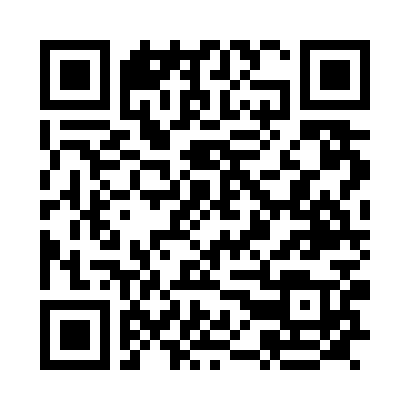

Practitioner ID: cd2e1ee7-891e-4cc9-b865-663b82d43fe9


In [4]:
# Simulating practitioner creating profile
with app.test_client() as client:
    client.post("/", data={
        "email": "demo@demo.com",
        "name": "Demo Practitioner",
        "pronouns": "she/her",
        "modalities": "yoga",
        "story": "Helping people feel calm"
    })

# Get practitioner ID
pract_id = list(practitioner_profiles.keys())[0]
print("Practitioner ID:", pract_id)


In [5]:
# Simulating client submitting feedback
with app.test_client() as client:
    r = client.post(f"/feedback/{pract_id}", data={
        "session_id": "S101",
        "question": "safety",
        "emotion_before": 4,
        "emotion_after": 9,
        "comment": "Felt very relaxed and safe."
    })
    print(r.status_code)
    print(r.data.decode())


/tmp/ipython-input-2400367845.py:96: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()
/tmp/ipython-input-2400367845.py:100: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  fname = f"feedback_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}.json"
ERROR:__main__:Exception on /feedback/cd2e1ee7-891e-4cc9-b865-663b82d43fe9 [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = sel

500
<!doctype html>
<html lang=en>
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>



In [6]:
print(practitioner_profiles[pract_id])


ImmutableMultiDict([('email', 'demo@demo.com'), ('name', 'Demo Practitioner'), ('pronouns', 'she/her'), ('modalities', 'yoga'), ('story', 'Helping people feel calm')])


In [7]:
from flask import Flask, request
import pyodbc
import pandas as pd
import qrcode

# Creating Flask app
app = Flask(__name__)


In [9]:
import pymssql
# connecting  the azuresql database
conn = pymssql.connect(
    server="smartfeedback-sql-signal.database.windows.net",
    user="sqladmin",
    password="Signal-dev",
    database="SmartFeedbackDB",
    port=1433
)

cursor = conn.cursor()
cursor.execute("SELECT @@SERVERNAME")
print(cursor.fetchone())


('smartfeedback-sql-signal',)


In [10]:
def get_public_impact(pract_id):
    return pd.read_sql(
        f"SELECT * FROM vw_PractitionerPublicImpact WHERE PractitionerID='{pract_id}'",
        conn
    )

def get_trends(pract_id):
    return pd.read_sql(
        f"SELECT * FROM vw_EmotionalStateTrends WHERE PractitionerID='{pract_id}' ORDER BY WeekNumber",
        conn
    )

def get_sentiments(pract_id):
    return pd.read_sql(
        f"SELECT * FROM vw_SentimentRollups WHERE PractitionerID='{pract_id}'",
        conn
    )


In [11]:

# this pulls analytics from Azure SQL views and renders them as a dashboard

@app.route("/practitioner/<pract_id>")
def practitioner_public(pract_id):


    impact = get_public_impact(pract_id)

    # Pull week-by-week emotional trend data
    trends = get_trends(pract_id)


    sentiments = get_sentiments(pract_id)

    # If the practitioner has no feedback yet, show a friendly message
    if impact.empty:
        return "No data yet for this practitioner."

    # Extracting key KPIs from the impact view
    avg_impact = round(impact["AvgImpact"][0], 2)
    positive_ratio = round(impact["PositiveRatio"][0] * 100, 1)
    total = int(impact["TotalResponses"][0])


    return f"""
    <h2>Practitioner {pract_id}</h2>

    <h3>Community Impact</h3>
    <p>Average Emotional Change: <b>{avg_impact}</b></p>
    <p>Clients Feeling Positive: <b>{positive_ratio}%</b></p>
    <p>Total Feedback: <b>{total}</b></p>

    <h3>Weekly Emotional Trend</h3>
    {trends.to_html(index=False)}

    <h3>Sentiment Breakdown</h3>
    {sentiments.to_html(index=False)}
    """



In [16]:
from google.colab import output
output.serve_kernel_port_as_iframe(5000)


<IPython.core.display.Javascript object>